# Application of second order ECM model to LFP battery test data 

The selected case for demonstration was 95k km. But other datasets can be also included by changing the following part in the 3rd chunk, provided that the folders are in Downloads Folder: 
Case_name = "95k_km_case"  Note that "_" must be added to the folder name!

Basics of second order ECM model is given below

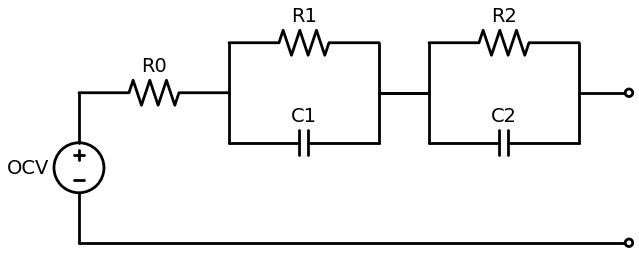

In [10]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
  
    d += elm.SourceV().label('OCV').up()
    
    d += elm.Resistor().label('R0').right()
     
    d.push()                     
    d += elm.Line().up().length(1)  
    d += elm.Resistor().label('R1').right()
    d += elm.Line().down().length(1)   

    d.pop()     
                        
    d.push()
    d += elm.Line().down().length(1)  
    d += elm.Capacitor().label('C1').right()
    d += elm.Line().up().length(1)    
    d.pop()
    d.move(dx=3) 
    
   
    d.push()      
    d += elm.Line().right().length(1)               
    d += elm.Line().up().length(1)  
    d += elm.Resistor().label('R2').right()
    d += elm.Line().down().length(1)   

    d.pop()                      
    
   
    d.push()
    d += elm.Line().right().length(1)  
    d += elm.Line().down().length(1) 
    d += elm.Capacitor().label('C2').right()
    d += elm.Line().up().length(1)     
    d.pop()

    d.move(dx=4)
    d += elm.Line().right().length(1) 
    d += elm.Dot(open=True)
   

    d.push()
    d.move(dy=-3,dx = -11)  # adjust depending on your SourceV height
    d += elm.Line().right().length(11)  # horizontal line at the bottom
    d += elm.Dot(open=True) #elm.Line().up().length(3) 
    
    d.pop()

The code follows these steps : 

- HPPC data loading
- OCV - SOC table generation
- ECM model parameter extraction from HPPC
- ECM model implementation
- Validation

In [11]:
#Read the folder content of the case
import os
import pandas as pd
from pathlib import Path
import numpy as np

Case_name = "95k_km_case" # Change for other cases, i.e. 206k_km_case or 300k_km_case
root_dir = os.path.expanduser(f"~/Downloads/{Case_name}") #Folder should be located at Downloads Folder
file_info = []

for foldername, subfolders, filenames in os.walk(root_dir):
    for filename in filenames:
        full_path = os.path.join(foldername, filename)
        rel_path = os.path.relpath(full_path, root_dir)
        rel_path_posix = Path(rel_path).as_posix() 
        parent_folder = os.path.basename(foldername)
        file_info.append({
            'Path': rel_path_posix,
            'Name': filename,
            'ParentFolder': parent_folder
        })

df_files = pd.DataFrame(file_info) # Al files are stored with their relative path

# HPPC tests were selected for parameter estimation since cyclic data may not have rest periods after current pulses
hppc_csvs = df_files[df_files['Name'].str.contains('HPPC.csv', na=False)].reset_index(drop = True) # This dataframe contains all HPPC.csv containing test file paths (similar could be done for .mat files)

# SOC dependent parameter fitting requires HPPC tests first Beginning of life (BOL) condition is used since usable capacity will be equal to nominal capacity  
index_hppc = hppc_csvs[hppc_csvs['ParentFolder']== "Cycle 0"].index[0] # This represents the cycle used for anlalysis below BOL conditions are used as a start 
filepath = hppc_csvs.iloc[index_hppc,0]
file_cycle = hppc_csvs.iloc[index_hppc,2]


In [12]:
#CSV files has some log information at the first few lines, determine where the test data start by following function
def find_header_line(filepath, header_name='Time Stamp'):
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            if line.strip().startswith(header_name):
                return i
    return None  # if header not found

In [13]:
header_line = find_header_line(os.path.join(root_dir, filepath), header_name='Time Stamp') #find where the test data start in the selected csv 

if header_line is not None:
    df_read = pd.read_csv( os.path.join(root_dir, filepath), skiprows=header_line) # Read CSV 
else:
    raise ValueError("Time Stamp line not found in file")

df = df_read.iloc[1:].reset_index(drop=True) #first row includes units etc, remove them
df = df.loc[:,'Time Stamp':'Capacity']

In [14]:
# Convert following columns to numeric since they will be used in the process
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df['Current'] = pd.to_numeric(df['Current'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce')
df['Prog Time'] = pd.to_timedelta(df['Prog Time'], errors='coerce')
df['Step Time'] = pd.to_timedelta(df['Step Time'], errors='coerce')
df['Step'] = pd.to_numeric(df['Step'], errors='coerce')
df['dt']= df["Prog Time"].diff().dt.total_seconds()
df.loc[0,'dt'] = 0

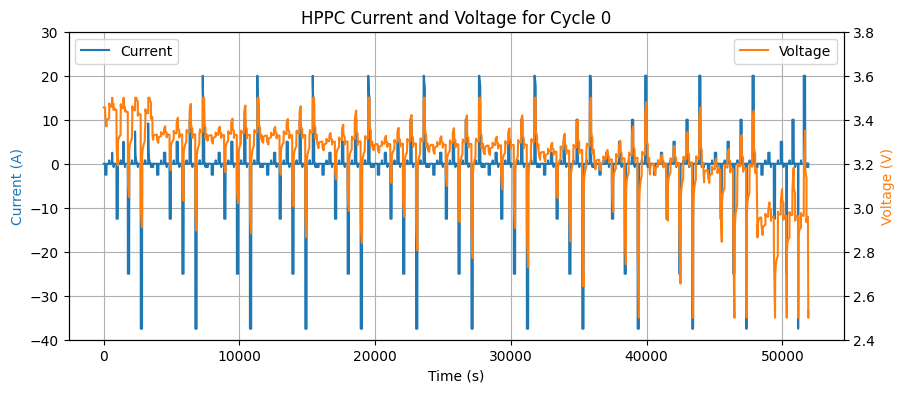

In [15]:
# Generate HPPC test plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(df.Current.values, label="Current", color='tab:blue')
plt.ylabel('Current (A)', color = 'tab:blue')
plt.xlabel("Time (s)")
plt.ylim(-40,30)
plt.legend(loc='upper left')
plt.title(f"HPPC Current and Voltage for {file_cycle}")
plt.grid(True)
ax2 = plt.gca().twinx()
ax2.plot(df.Voltage.values, label="Voltage", color='tab:orange')
ax2.set_ylabel('Voltage (V)', color='tab:orange')
ax2.set_ylim(2.4,3.8)
ax2.legend(loc='upper right')
plt.show()

# OCV and SoC estimation

OCV can be estimated from HPPC pulses, it will be the point where the battery rests between pulses (current ~ 0) and stable voltage reading is achieved

In [16]:
current_threshold = 0.02  # 0.02 Amps considering noise in the measurement
voltage_change_threshold = 0.002  # 2 mV difference between 2 consecutive times

window_points = 150 # 15 second window at 100 ms sampling rate
half_window = window_points // 2


def is_voltage_stable_rolling(idx):
    if idx < half_window or idx + half_window >= len(df):
        return False
    window = df.iloc[idx - half_window : idx + half_window + 1]['Voltage']
    return (window.max() - window.min()) < voltage_change_threshold

rest_mask = (df['Current'].abs() < current_threshold) & df.index.to_series().apply(is_voltage_stable_rolling)

df['OCV_estimate'] = np.nan 

# Get indices where rest condition is satisfied
rest_indices = df.index[rest_mask]

# For each rest index, take the mean of the last 5 stable voltage values
for idx in rest_indices:
    if idx >= 4:  # Ensure at least 5 previous points are available
        ocv_value = df.loc[idx - 4:idx, 'Voltage'].mean()
        df.at[idx, 'OCV_estimate'] = ocv_value


In [17]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index, y=df['Voltage'],
    mode='lines', name='Voltage', line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df.index[rest_mask], y=df['Voltage'][rest_mask],
    mode='markers', name='OCV estimate (rest)', marker=dict(color='red', size=8, symbol='circle')
))

fig.add_trace(go.Scatter(
    x=df.index, y=df['Current'],
    mode='lines', name='Current', line=dict(color='orange', dash='dot'), yaxis='y2'
))

fig.update_layout(
    title='Voltage, Current, and OCV Rest Points',
    xaxis_title='Index',
    yaxis=dict(title='Voltage (V)', side='left'),
    yaxis2=dict(title='Current (A)', overlaying='y', side='right', showgrid=False),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    height=500,
)

fig.show()

Mostly coulumb counting is used for SoC determination but at BOL we can use capacity column to estimate SoC at any given point since nominal capacity = usable capacity 

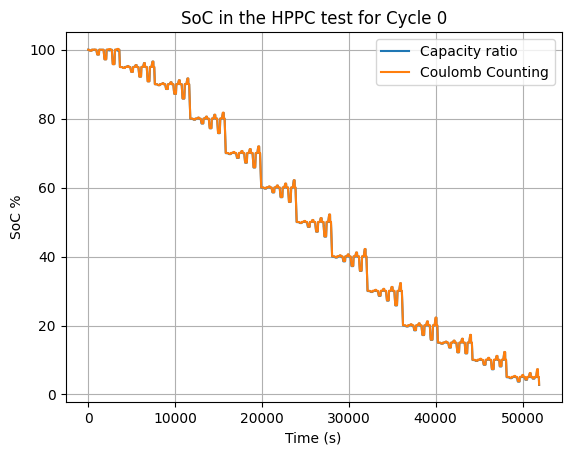

In [18]:
# assuming the Hppc test start at 100% SoC we can find instantaneous SoC(t) as 1 - Capacity (t)/ CapacityNominal where CapacityNominal is 2.5 Ah 
Q_nom = 2.5  #  nominal capacity (Ah)
Soc = (1- abs(df.Capacity.values)/Q_nom)*100
SoC = pd.DataFrame(Soc)
df['SoC'] = SoC

# Coulomb counting
df_cc = df.copy()
df_cc['delta_t_h'] = df_cc['dt'] / 3600 #convert time difference to hours since Capacity is in Ah 
df_cc['dAh'] = df_cc['Current'] * df_cc ['delta_t_h']
df_cc['Cumulatif_Ah_Change'] = np.cumsum (df_cc['dAh'])
SoC_init = 1
df_cc["Soc_cc"]= 1 + df_cc['Cumulatif_Ah_Change']/Q_nom

plt.plot(SoC, label = "Capacity ratio")
plt.plot(df_cc.Soc_cc*100, label = "Coulomb Counting")
plt.ylabel("SoC %")
plt.xlabel("Time (s)")
plt.title(f"SoC in the HPPC test for {file_cycle}")
plt.grid(True)
plt.legend()
plt.show()

They result in the same way, hence any SoC value can be used. OCV vs SoC % is interpolated for future

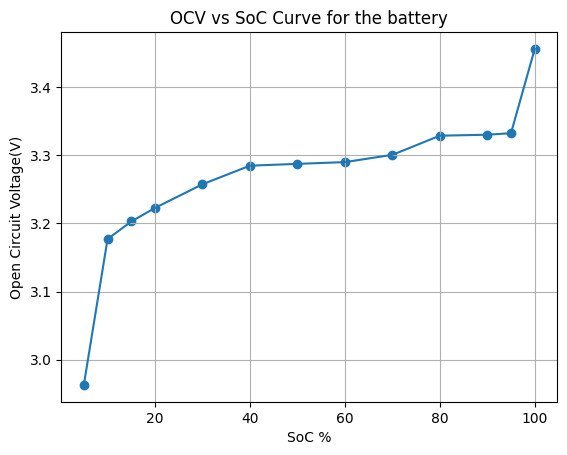

In [19]:
from scipy.interpolate import PchipInterpolator

df_ocv = df[~np.isnan(df['OCV_estimate'])].copy() #filter out only present OCV values
df_ocv['SoC_rounded'] = df_ocv['SoC'].round(2)  # round to 2 decimal places

ocv_lookup = df_ocv.groupby('SoC_rounded')['OCV_estimate'].mean().reset_index() # Group by SoC and calculate mean of OCV_estimate
ocv_lookup.loc[-1,'SoC_rounded'] = 100
ocv_lookup.loc[-1,'OCV_estimate'] = df.loc[0,'Voltage']

ocv_to_soc = PchipInterpolator(ocv_lookup.OCV_estimate, ocv_lookup.SoC_rounded, extrapolate=True) # for mapping in the future
soc_to_ocv = PchipInterpolator(ocv_lookup.SoC_rounded, ocv_lookup.OCV_estimate, extrapolate=True) # for mapping in the future

plt.scatter(ocv_lookup.SoC_rounded, ocv_lookup.OCV_estimate)
plt.plot(ocv_to_soc(ocv_lookup.OCV_estimate), ocv_lookup.OCV_estimate)
plt.title("OCV vs SoC Curve for the battery")
plt.xlabel("SoC %")
plt.ylabel("Open Circuit Voltage(V)")
plt.grid(True)
plt.show()

# ECM parameter extraction for second order model

Multi pulses can be separated using Step number, as test continues the step starts from 1 to 40 and then drops, hence each time step = 1 will be beginning of new SoC range pulses

In [20]:
df_step = df.copy()

df_step['is_one'] = df_step['Step'] == 1

# Find start of each run of 1s or non-1s
df_step['change'] = df_step['Step'].ne(df_step['Step'].shift())

# Get the indices where these runs start
start_indices = df_step.index[df_step['change'] & df_step['is_one']].tolist()
start_indices.append(len(df_step)) 

# Slice between these indices
list_of_dfs = [df.iloc[start_indices[i]:start_indices[i+1]] for i in range(len(start_indices)-1)]
print(f"Number of sequences found: {len(list_of_dfs)}")

Number of sequences found: 13


Within these 13 sequences there are multiple charge and discharge pulses, at the end of each pulse a relaxation time is found so that Voltage decay can be fitted for parameter extraction (R1,C1,R2,C2). R0 is found by the voltage difference divided by current difference at the begginning of the pulse.
For each pulse sequences the identified  valid pulses are marked and OCV determined is plotted as a purple dot. 

In [21]:
from plotly.subplots import make_subplots
from scipy.optimize import curve_fit

def double_exp(t, A1, tau1, A2, tau2, V_inf):
        return V_inf + A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) # The eqn for Voltage relaxation part (after voltage drop occurs)
parameters_pulses = []
for seq in range(len(list_of_dfs)):
    pulse_df = list_of_dfs[seq].reset_index(drop = True)
    pulse_threshold = 0.85  # amps, noise floor

    # Identify pulse start and end indices based on current changes
    is_pulse = np.abs(pulse_df["Current"]) > pulse_threshold
    pulse_changes = np.diff(is_pulse.astype(int))

    # pulse_changes will be 1 where a pulse starts and -1 where it ends
    raw_starts = np.where(pulse_changes == 1)[0] + 1
    raw_ends = np.where(pulse_changes == -1)[0] + 1

    # Filter based on current stability
    valid_starts = []
    valid_ends = []
    for start, end in zip(raw_starts, raw_ends):
        pulse_currents = pulse_df.loc[start+1:start+50, 'Current'] 
        if pulse_currents.max() - pulse_currents.min() < pulse_threshold:  # Stability threshold the start and end current difference should be less than 1 A for pulses
            valid_starts.append(start)
            valid_ends.append(end)
        else:
            print(f"Dropped unstable pulse from {start} to {end}, ΔI = {pulse_currents.max() - pulse_currents.min():.3f} A")

    pulse_starts = np.array(valid_starts)
    pulse_ends = np.array(valid_ends)

    print(f"Detected {len(pulse_starts)} pulses.")
    time = range(len(pulse_df))
    
    for pul in range(len(pulse_starts)):
        pulse_start = pulse_starts[pul]-5 # get few time steps before for Voltage reading before pulse
        pulse_end = pulse_ends[pul]
        time_try = 200
        if np.any(np.abs(pulse_df.Current[pulse_end:pulse_end+time_try]) > 0.1):
            t_exp = 100
            
        else:   
            t_exp = 200
            
        pulse_final = pulse_end + t_exp 
        segment = pulse_df[pulse_start:pulse_final].reset_index(drop=True)

        delta = segment['Current'].diff().abs()
        sudden_changes = segment.index[delta > 0.5]
        
        V_start = segment.Voltage[sudden_changes[0]-1]
        V_drop = segment.Voltage[sudden_changes[0]+1]
        I = segment.Current[sudden_changes[0]] # Current changes from 0 to pulse current
        R0 = abs(V_start - V_drop)/abs(I) #R0 is dV/dI, since pulses have both increase and decrease, use absolute values

        end_current = abs(segment.Current[sudden_changes[1]])<0.1 #for relaxation curve fitting current must be ~ 0. Consider noise with 0.05 A threshold
        
        if end_current:
            relax_starts = sudden_changes[1]
            relax_ends = pulse_final - pulse_start
            time_relaxation = relax_ends - relax_starts
            t_relax = np.linspace(0, time_relaxation-1, time_relaxation) # numpy array format
            v_relaxation = segment.Voltage[relax_starts:relax_ends].reset_index(drop=True)
            v_relax = v_relaxation.values # numpy array format
            i_relaxation = segment.Current[relax_starts:relax_ends].reset_index(drop=True)
            
            assert np.all(np.abs(i_relaxation) < 0.1), "Current is not zero in relaxation segment!"

                
            p0 = [0.02, 5, 0.01, 50, v_relax[-1]]
            bounds = ([-1, 0.01, -1, 0.01, v_relax.min()], [1, 500, 1, 1000, v_relax.max()])

        # Fit
            params_ext, _ = curve_fit(double_exp, t_relax, v_relax, p0=p0, bounds=bounds, maxfev=10000)
            A1, tau1, A2, tau2, V_inf = params_ext

            pulse_current = (segment[segment.index< sudden_changes[1]]['Current'].iloc[-1])

            # Calculate R and C
            R1 = A1 / pulse_current
            C1 = tau1 / R1 if R1 != 0 else np.nan
            R2 = A2 / pulse_current
            C2 = tau2 / R2 if R2 != 0 else np.nan

            results = [seq, pul, pulse_final, v_relax[-1], pulse_current, R0, R1, R2, C1, C2]
            parameters_pulses.append(results)
            print("parameters are : ")
            print(results)
        else:
            print("Not 0 or stable Current")   
    Map = pd.DataFrame(parameters_pulses, columns=["segment", "pulse", "OCV_time", "OCV","pulse_current", "R0", "R1", "R2", "C1", "C2"])
    
    # Verify detected pulses
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(x=pulse_df.index, y=pulse_df["Current"], name='Current', mode='lines'),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=pulse_df.index, y=pulse_df["Voltage"], name='Voltage', mode='lines', line=dict(color="orange")),
        secondary_y=True,
    )
    ind = Map.segment == seq
    # Add OCV scatter points
    fig.add_trace(
        go.Scatter(x=Map.loc[ind,"OCV_time"], y=Map.loc[ind,"OCV"], mode='markers', name='OCV',
                marker=dict(size=8, color='purple', symbol='circle')),
        secondary_y=True,
    )
    for s, e in zip(pulse_starts, pulse_ends):
        fig.add_vrect(
            x0=time[s], x1=time[e],
            fillcolor="red", opacity=0.3, layer="below", line_width=0,
            name=f'Pulse: {time[s]:.2f}-{time[e]:.2f}s' # Name for hover info
        )

    fig.update_layout(
        title_text=f"Detected Current Pulses for sequence {seq}",
        xaxis_title="Time (s)",
        hovermode="x unified" 
    )

    fig.update_yaxes(title_text="Current (A)", secondary_y=False)
    fig.update_yaxes(title_text="Voltage (V)", secondary_y=True)
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey', secondary_y=True)


    fig.show()


Dropped unstable pulse from 608 to 627, ΔI = 2.497 A
Dropped unstable pulse from 1456 to 1462, ΔI = 4.995 A
Dropped unstable pulse from 2308 to 2370, ΔI = 5.738 A
Dropped unstable pulse from 3274 to 3354, ΔI = 7.083 A
Detected 4 pulses.
parameters are : 
[0, 0, 402, 3.4056, -2.4972, 0.008072573232625982, 0.00356020958528786, 0.005560237634302571, 505.48450912045837, 11414.253514072028]
parameters are : 
[0, 1, 1237, 3.3296, -12.4989, 0.008328732928497732, 0.0008378499169136411, 0.0027164001506610495, 4657.695815354424, 24782.284744643574]
parameters are : 
[0, 2, 2072, 3.3112, -25.0004, 0.008323866818130927, 0.0008154642034801661, 0.0021812638178472384, 5089.086438219665, 30771.542800975752]
parameters are : 
[0, 3, 3021, 3.3009, -37.4993, 0.008405490235817733, 0.0008362655293003105, 0.0019880545371099324, 5241.091934156046, 33195.05507913612]


Dropped unstable pulse from 3471 to 3572, ΔI = 6.223 A
Detected 7 pulses.
parameters are : 
[1, 0, 402, 3.3252, -2.4998, 0.007553051192902497, 0.0035099068900347743, 0.0036036791310779318, 400.6540906192494, 19046.39776398716]
parameters are : 
[1, 1, 809, 3.3416, 2.4973, 0.007480598447875806, 0.0029981393168895605, 0.00344234395665367, 362.2111050854382, 10285.710050904074]
parameters are : 
[1, 2, 1322, 3.3095, -12.4989, 0.00791269631727592, 0.0008389867810860397, 0.002778086172669645, 4201.335034805383, 24649.303697356987]
parameters are : 
[1, 3, 1742, 3.3512, 4.9971, 0.007420445226713541, 0.0025661570038473538, 0.003337067385799541, 446.6409761137934, 10358.511408619199]
parameters are : 
[1, 4, 2258, 3.2982, -25.0004, 0.007911873410025439, 0.000815146502434059, 0.0022536261209725136, 4748.6244751892455, 30418.78094387704]
parameters are : 
[1, 5, 2695, 3.3599, 9.9994, 0.007462387964148549, 0.0009131292471137838, 0.002978856897386546, 2440.986032000786, 11461.789541381679]
paramet

Dropped unstable pulse from 3471 to 3572, ΔI = 5.545 A
Detected 7 pulses.
parameters are : 
[2, 0, 402, 3.3228, -2.4972, 0.007353235023778202, 0.002914064617744302, 0.003909872699815922, 482.60664720130086, 16613.966677230375]
parameters are : 
[2, 1, 809, 3.339, 2.4973, 0.007360588847107846, 0.003893048496002176, 0.0034633705929191733, 232.9132076217751, 10326.781167719097]
parameters are : 
[2, 2, 1322, 3.3046, -12.4989, 0.007920697021337858, 0.0008733548817111806, 0.0029568117755441777, 3786.642109160893, 23804.972802883243]
parameters are : 
[2, 3, 1742, 3.3486, 4.9971, 0.007560453627217689, 0.0032009503123536925, 0.003124619743146824, 300.3940309479089, 11393.884531744125]
parameters are : 
[2, 4, 2258, 3.2904, -25.0004, 0.007887873794019298, 0.0008257097772222205, 0.0022874934115889234, 4454.763515221335, 29948.003407215478]
parameters are : 
[2, 5, 2695, 3.3576, 9.9968, 0.007322343149807931, 0.0008008570565732325, 0.0026101237768422682, 2666.970360793, 13411.352197000344]
parame

Dropped unstable pulse from 3471 to 3572, ΔI = 5.319 A
Detected 7 pulses.
parameters are : 
[3, 0, 402, 3.3201, -2.4972, 0.00763297766055225, 0.003112322117346614, 0.004271604198943236, 509.77779112258105, 15568.31406078676]
parameters are : 
[3, 1, 809, 3.3378, 2.4973, 0.0075606048483880155, 0.002825644972763879, 0.003409091666798194, 415.01552926560873, 10622.48734263175]
parameters are : 
[3, 2, 1322, 3.2948, -12.4989, 0.00798470265383351, 0.0009792200674172652, 0.003015675100912924, 3128.2072947351985, 23207.772107925262]
parameters are : 
[3, 3, 1742, 3.3478, 4.9971, 0.007540452427145554, 0.003214744992964983, 0.002975014661383905, 293.9893907202243, 11930.891336524435]
parameters are : 
[3, 4, 2258, 3.2783, -25.0004, 0.007967872514039786, 0.0008594870538078738, 0.002251016265222266, 4129.38593441682, 30018.228929001318]
parameters are : 
[3, 5, 2695, 3.3572, 9.9968, 0.007442381562099896, 0.0007350756392908992, 0.0024108077275132142, 2688.767448669107, 14734.906934579278]
paramete

Dropped unstable pulse from 3471 to 3572, ΔI = 3.416 A
Detected 7 pulses.
parameters are : 
[4, 0, 402, 3.2925, -2.4972, 0.007553051192902497, 0.0032986723943856542, 0.00396678319177833, 439.51313216675476, 16426.98379659831]
parameters are : 
[4, 1, 809, 3.3102, 2.4973, 0.007600608048643942, 0.0027240447558660136, 0.0033517065072250726, 429.0899262185528, 10592.442101311197]
parameters are : 
[4, 2, 1322, 3.2739, -12.4989, 0.008056708990391136, 0.0010496296571410756, 0.0027434544639396144, 3273.3921623926476, 24644.644607697483]
parameters are : 
[4, 3, 1742, 3.3216, 4.9971, 0.007680460827649613, 0.0033221880080433917, 0.0029652943501569566, 317.5780623550026, 11882.357641420007]
parameters are : 
[4, 4, 2258, 3.2636, -25.0004, 0.008191868930097122, 0.0011100001767392995, 0.002259927270084629, 2911.2139066756517, 29226.933022633846]
parameters are : 
[4, 5, 2695, 3.3363, 9.9968, 0.0074123719590268936, 0.000654085758822292, 0.0025153556815622233, 3047.591021343595, 14364.798422105176]


Dropped unstable pulse from 3471 to 3572, ΔI = 1.203 A
Detected 7 pulses.
parameters are : 
[5, 0, 402, 3.2825, -2.4998, 0.007832793829676723, 0.0038031718783536825, 0.004073012967164728, 395.3377708568383, 16250.342070218549]
parameters are : 
[5, 1, 809, 3.2977, 2.4973, 0.007560604848387838, 0.003102954303001677, 0.0032584485042782873, 354.4940972722558, 11054.983380835944]
parameters are : 
[5, 2, 1322, 3.2648, -12.4989, 0.008096712510700937, 0.0012569713140327535, 0.0031107842182767935, 2763.9071810099667, 21777.951184599344]
parameters are : 
[5, 3, 1742, 3.3082, 4.9971, 0.007540452427145642, 0.0032071785638224317, 0.0027823055062549808, 292.8844403729984, 12715.91796894038]
parameters are : 
[5, 4, 2258, 3.2528, -25.0004, 0.008275867586118625, 0.0013154675207471837, 0.002554490457795052, 2693.655043081386, 26153.765263635134]
parameters are : 
[5, 5, 2695, 3.3193, 9.9994, 0.007420445226713585, 0.0006757832633910102, 0.002200431829833979, 3045.63931244726, 16164.574339886904]
para

Dropped unstable pulse from 3471 to 3572, ΔI = 0.929 A
Detected 7 pulses.
parameters are : 
[6, 0, 402, 3.279, -2.4998, 0.007912720297326476, 0.0036090145794969073, 0.004314266303239794, 411.3304720270624, 15173.183611763714]
parameters are : 
[6, 1, 809, 3.2957, 2.4973, 0.007720617649411902, 0.0030032492422790787, 0.0033928451841404813, 324.3904350104234, 10759.378943971758]
parameters are : 
[6, 2, 1322, 3.2572, -12.4989, 0.008296730112249906, 0.001416269818090025, 0.0033365175841525373, 2637.8762607177464, 20365.679183429034]
parameters are : 
[6, 3, 1742, 3.3063, 4.9971, 0.007620457227433651, 0.002954052363436818, 0.0028479887910434288, 357.8348497843023, 12921.523118740923]
parameters are : 
[6, 4, 2258, 3.242, -25.0004, 0.008299867202124767, 0.0015767746150862955, 0.0027611173195080073, 2347.0102903231013, 23940.89112659776]
parameters are : 
[6, 5, 2695, 3.3174, 9.9968, 0.007540452427145642, 0.0006206309417523525, 0.0022310715905615175, 3129.3876619849716, 15971.596283654646]
pa

Dropped unstable pulse from 3471 to 3572, ΔI = 0.893 A
Detected 7 pulses.
parameters are : 
[7, 0, 402, 3.2746, -2.4998, 0.007784741905864623, 0.0032052369830064013, 0.004492253471994749, 672.7766158674902, 14703.650407367859]
parameters are : 
[7, 1, 809, 3.2931, 2.4973, 0.007680614449155975, 0.003069091060616338, 0.003401258551627229, 335.9059385225215, 10799.872876445073]
parameters are : 
[7, 2, 1322, 3.2496, -12.4989, 0.008256726591940105, 0.0017349539811178565, 0.0034849874187246267, 2333.4356812118135, 19049.104279510775]
parameters are : 
[7, 3, 1742, 3.3053, 4.9971, 0.007580454827289647, 0.002937064511681019, 0.002800929602928241, 327.1406384462934, 12836.908324334006]
parameters are : 
[7, 4, 2258, 3.2324, -25.0004, 0.008355866306139114, 0.0020362006164486523, 0.0029672427609447006, 1980.3844665773595, 21817.896434314713]
parameters are : 
[7, 5, 2695, 3.3174, 9.9968, 0.007480448826929636, 0.0006319135412441522, 0.0021954953402609514, 3040.452047602729, 16402.34505181472]
par

Detected 8 pulses.
parameters are : 
[8, 0, 402, 3.2449, -2.4972, 0.007832793829676546, 0.004374664738052891, 0.004903253364336757, 367.52655720966146, 13176.661306316526]
parameters are : 
[8, 1, 809, 3.2656, 2.4973, 0.007680614449155797, 0.003017546991128075, 0.003453977595720943, 357.59707758596426, 10587.323058305723]
parameters are : 
[8, 2, 1322, 3.221, -12.4989, 0.008328732928497732, 0.002315908030964846, 0.0038535770875780693, 1996.7294326845276, 17032.95558138811]
parameters are : 
[8, 3, 1742, 3.2812, 4.9971, 0.007800468028081625, 0.0029098379465264572, 0.0027838315950787554, 333.24360268455297, 12979.471867667462]
parameters are : 
[8, 4, 2258, 3.2012, -25.0004, 0.008459864642165726, 0.002712446378832269, 0.003342838590351187, 1787.784560530397, 19266.28769469459]
parameters are : 
[8, 5, 2695, 3.2985, 9.9968, 0.00758242637644047, 0.0006191264033929776, 0.0022290624488223365, 2748.269046184818, 16240.013158595439]
parameters are : 
[8, 6, 3218, 3.185, -37.4993, 0.00848815844

Detected 8 pulses.
parameters are : 
[9, 0, 402, 3.2076, -2.4998, 0.007832793829676723, 0.004289264272415565, 0.005453265601868598, 413.56034371816315, 11642.862659728422]
parameters are : 
[9, 1, 809, 3.2323, 2.4973, 0.007960636850948177, 0.0028341475761488348, 0.0035614335812119867, 376.45095858163006, 10251.707358873085]
parameters are : 
[9, 2, 1322, 3.1783, -12.4989, 0.00838473785693141, 0.0031304346091517036, 0.004492371174752143, 1745.6949140227393, 14138.359145696]
parameters are : 
[9, 3, 1742, 3.2491, 4.9971, 0.007804526625442786, 0.00319403724823457, 0.002847042002809876, 299.1443316231469, 12817.25909560711]
parameters are : 
[9, 4, 2258, 3.1592, -25.0004, 0.008523863618182121, 0.004206097900314129, 0.00432154533912196, 1485.8626143271076, 13951.565426262612]
parameters are : 
[9, 5, 2695, 3.266, 9.9968, 0.007492397567221507, 0.0006080359191936108, 0.002289633834870355, 2796.714550042417, 16017.018371335795]
parameters are : 
[9, 6, 3218, 3.1432, -36.8319, 0.008461491281170

Detected 8 pulses.
parameters are : 
[10, 0, 402, 3.1874, -2.4998, 0.008072573232625982, 0.004251980754573853, 0.005802373726830991, 475.321948729426, 11101.459548496598]
parameters are : 
[10, 1, 809, 3.212, 2.4973, 0.007760620849667829, 0.0030488058288985075, 0.003548143691933064, 350.78600718088296, 10189.660891185997]
parameters are : 
[10, 2, 1322, 3.1592, -12.4989, 0.008352735040683583, 0.0037896222124155416, 0.005516685520220951, 1594.1309161325903, 11336.768106735899]
parameters are : 
[10, 3, 1742, 3.2267, 4.9971, 0.007880472828369723, 0.002902637976016733, 0.002753096995392418, 340.6061705948526, 13316.733380993759]
parameters are : 
[10, 4, 2258, 3.131, -25.0004, 0.008459864642165726, 0.005145646526037738, 0.005866147336331725, 1400.315028984213, 10300.170992904272]
parameters are : 
[10, 5, 2695, 3.2415, 9.9968, 0.007670460227613634, 0.0006188175147305371, 0.002278636507819779, 2828.405672918781, 16037.190686159754]
parameters are : 
[10, 6, 3191, 3.1284, -36.2431, 0.008554

Dropped unstable pulse from 2912 to 2957, ΔI = 37.499 A
Detected 7 pulses.
parameters are : 
[11, 0, 402, 3.1543, -2.4998, 0.008032609998801017, 0.0042926392105743895, 0.0065491855751878755, 557.7360189622797, 9579.883521777245]
parameters are : 
[11, 1, 809, 3.1916, 2.4973, 0.007960636850947998, 0.0029718188709678033, 0.003984520076600353, 362.505684883983, 9047.91024220217]
parameters are : 
[11, 2, 1322, 3.0889, -12.4989, 0.008312731520373819, 0.0047116408251078054, 0.0067486204823650415, 1431.5853845630352, 9027.5970562574]
parameters are : 
[11, 3, 1742, 3.2108, 4.9971, 0.007764503411978893, 0.0035078517067842594, 0.0029712866439021673, 248.8174517693599, 12295.340043087655]
parameters are : 
[11, 4, 2254, 3.0128, -23.97, 0.008615862146205654, 0.005855151770579944, 0.007430818008772608, 1452.9538536287691, 7844.813467451591]
parameters are : 
[11, 5, 2690, 3.229, 9.9994, 0.007752480793854046, 0.0005959977256288712, 0.002155615035932593, 2895.933653136845, 16951.45996900078]
parame

Dropped unstable pulse from 1948 to 1976, ΔI = 25.000 A
Dropped unstable pulse from 2810 to 2821, ΔI = 37.499 A
Detected 6 pulses.
parameters are : 
[12, 0, 402, 2.9219, -2.4998, 0.008512168804699537, 0.004589965429979452, 0.007372561174748831, 672.9297004726535, 8535.88460472223]
parameters are : 
[12, 1, 809, 2.9904, 2.4973, 0.008720697655812393, 0.003335696404251223, 0.00453203131296142, 325.8694297786049, 7550.54284467617]
parameters are : 
[12, 2, 1314, 2.7795, -11.7046, 0.008920785029082553, 0.006279727674158752, 0.008986038646034963, 1171.3176344721453, 6566.809893295838]
parameters are : 
[12, 3, 1733, 3.0236, 4.9971, 0.008400504030241866, 0.0031423942220995386, 0.0036263395519601483, 342.397885976472, 9626.740491429611]
parameters are : 
[12, 4, 2588, 3.0681, 9.9968, 0.008680520831249853, 0.0007187727586346308, 0.0030745639035491545, 2891.560149634814, 11644.441551048947]
parameters are : 
[12, 5, 3429, 3.1378, 20.0013, 0.008669436486628369, 0.0005748462070612061, 0.0026546838

In [22]:
Map["SOC"] = Map["OCV"].apply(ocv_to_soc)
Map['Type'] = Map['pulse_current'].apply(lambda x: 'charge' if x > 0 else ('discharge' if x < 0 else 'rest'))
Map #result table of the fits for each pulses and segments

segment  pulse  OCV_time     OCV  pulse_current        R0        R1  \
0         0      0       402  3.4056        -2.4972  0.008073  0.003560   
1         0      1      1237  3.3296       -12.4989  0.008329  0.000838   
2         0      2      2072  3.3112       -25.0004  0.008324  0.000815   
3         0      3      3021  3.3009       -37.4993  0.008405  0.000836   
4         1      0       402  3.3252        -2.4998  0.007553  0.003510   
..      ...    ...       ...     ...            ...       ...       ...   
85       12      1       809  2.9904         2.4973  0.008721  0.003336   
86       12      2      1314  2.7795       -11.7046  0.008921  0.006280   
87       12      3      1733  3.0236         4.9971  0.008401  0.003142   
88       12      4      2588  3.0681         9.9968  0.008681  0.000719   
89       12      5      3429  3.1378        20.0013  0.008669  0.000575   

          R2           C1            C2        SOC       Type  
0   0.005560   505.484509  11414.253514  99.589097  discharge  
1   0.002716  4657.695815  24782.284745  86.878389  discharge  
2   0.002181  5089.086438  30771.542801  73.180348  discharge  
3   0.001988  5241.091934  33195.055079  70.219631  discharge  
4   0.003604   400.654091  19046.397764  77.351896  discharge  
..       ...          ...           ...        ...        ...  
85  0.004532   325.869430   7550.542845   5.064291     charge  
86  0.008986  1171.317634   6566.809893   7.009440  discharge  
87  0.003626   342.397886   9626.740491   5.330407     charge  
88  0.003075  2891.560150  11644.441551   6.055968     charge  
89  0.002655  3078.627837  13479.796328   8.188177     charge  

[90 rows x 12 columns]

Initial extracted parameters are stored in Map dataframe. As well as SoC, the charge or discharge effect the parameters, hence pulse current sign is used in determination of type of current. 
Since the parameters are noisy wrt SoC for both discharge and charge, simplest smoothing method - moving average- is used , window is selected as 3 for resistances, and 5 for capacitances

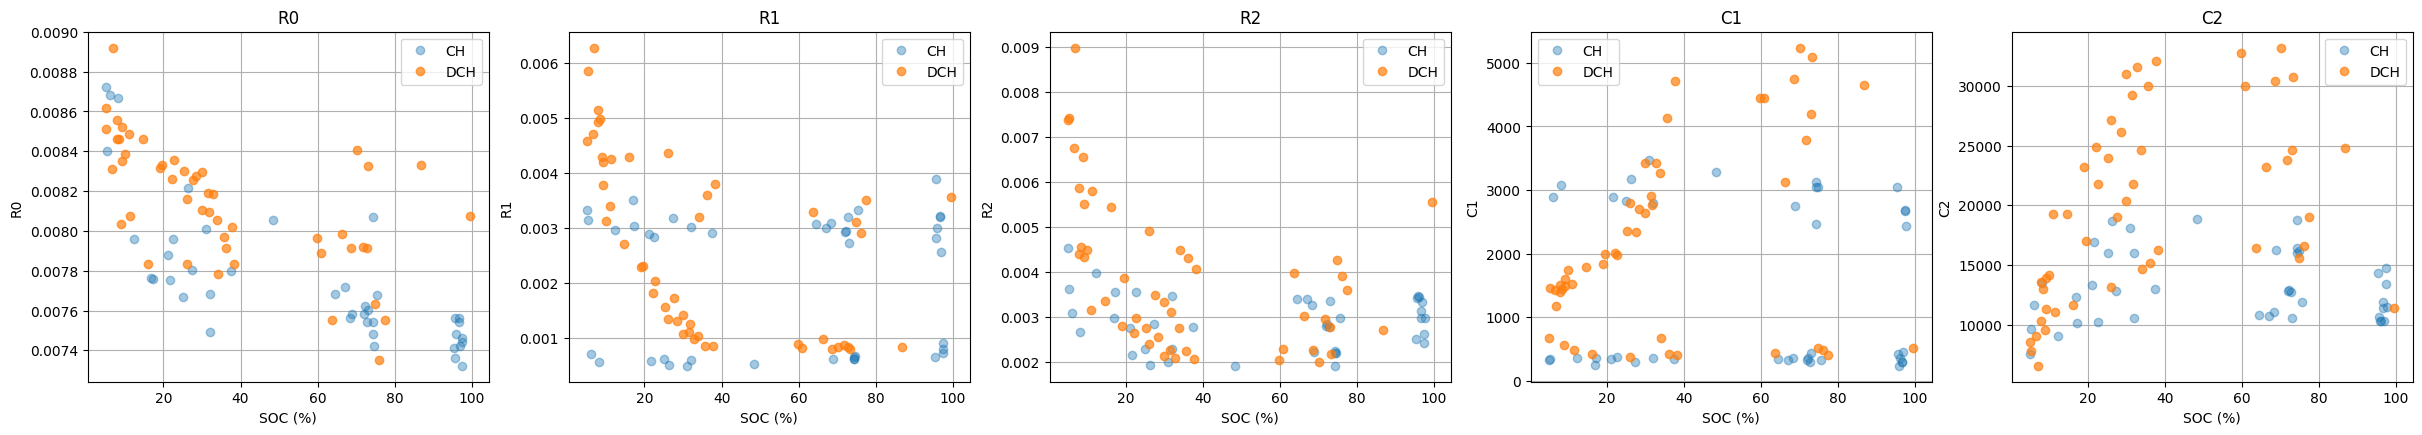

In [23]:
Map_ch = Map[Map.Type == "charge"].copy()
Map_dch = Map[Map.Type == "discharge"].copy()

plt.figure(figsize=(30, 10))
for i, col in enumerate(['R0', 'R1', 'R2', 'C1', 'C2']):
    plt.subplot(2, 5, i + 1)
    plt.plot(Map_ch['SOC'], Map_ch[col], 'o', alpha=0.4, label='CH')
    plt.plot(Map_dch['SOC'], Map_dch[col], 'o', alpha=0.7, label='DCH')
    plt.title(col)
    plt.legend()
    plt.xlabel('SOC (%)')
    plt.ylabel(col)
    plt.grid(True)

In [24]:
def moving_average(data, w):
    return pd.Series(data).rolling(window=w, center=True, min_periods=1).mean().values

In [25]:
Map_ch["R0_ma"] = moving_average(Map_ch["R0"], 3)
Map_ch["R1_ma"] = moving_average(Map_ch["R1"], 3)
Map_ch["R2_ma"] = moving_average(Map_ch["R2"], 3)
Map_ch["C1_ma"] = moving_average(Map_ch["C1"], 5)
Map_ch["C2_ma"] = moving_average(Map_ch["C2"], 5)

Map_dch["R0_ma"] = moving_average(Map_dch["R0"], 3)
Map_dch["R1_ma"] = moving_average(Map_dch["R1"], 3)
Map_dch["R2_ma"] = moving_average(Map_dch["R2"], 3)
Map_dch["C1_ma"] = moving_average(Map_dch["C1"], 5)
Map_dch["C2_ma"] = moving_average(Map_dch["C2"], 5)

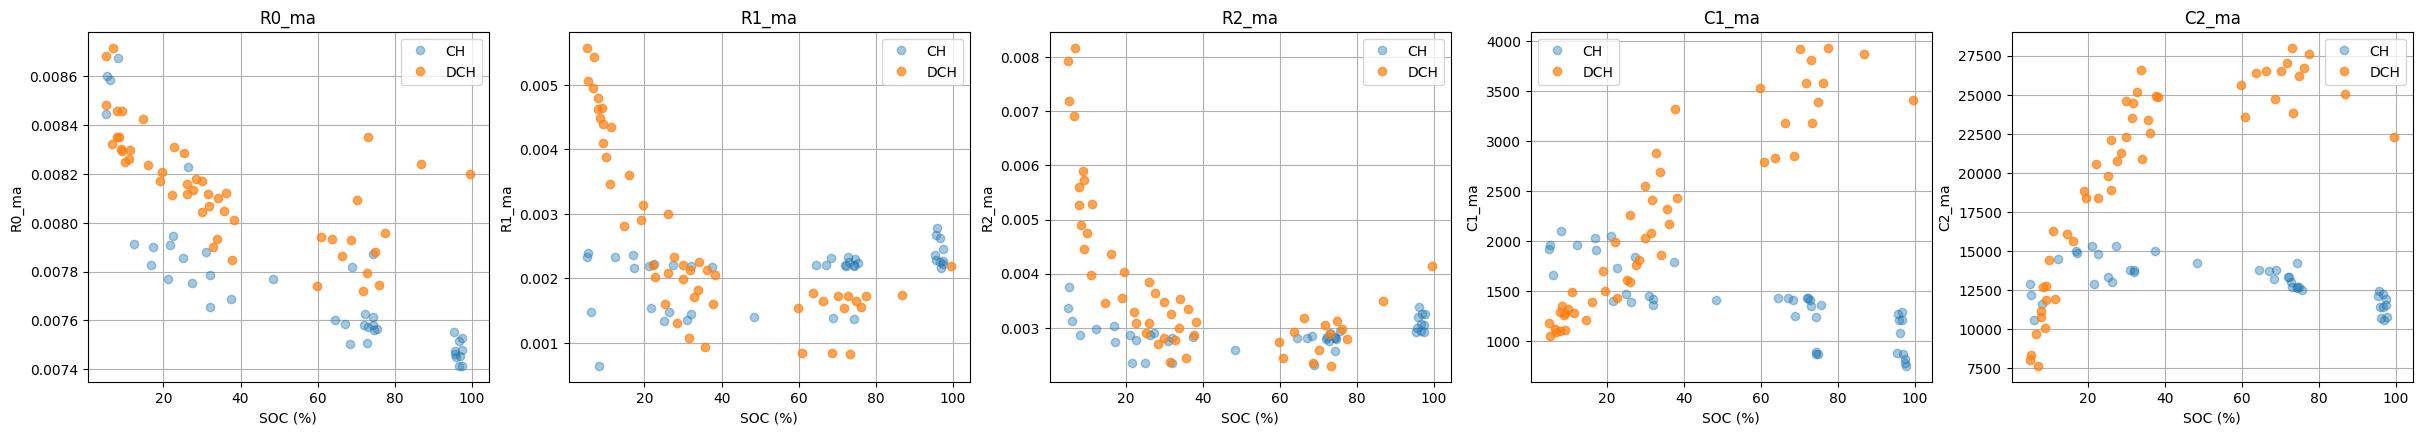

In [26]:
plt.figure(figsize=(30, 10))
for i, col in enumerate(['R0_ma', 'R1_ma', 'R2_ma', 'C1_ma', 'C2_ma']):
    plt.subplot(2, 5, i + 1)
    plt.plot(Map_ch['SOC'], Map_ch[col], 'o', alpha=0.4, label='CH')
    plt.plot(Map_dch['SOC'], Map_dch[col], 'o', alpha=0.7, label='DCH')
    plt.title(col)
    plt.legend()
    plt.xlabel('SOC (%)')
    plt.ylabel(col)
    plt.grid(True)

The plots show some expected behaviours now. Most of the trends match with literature.

ECM implementation requires mapping of parameters to SoC and creating an iterative loop for continuous soc and terminal voltage update

In [27]:
from scipy.interpolate import interp1d

interp_charge_R0 = interp1d(Map_ch[Map_ch['Type'] == 'charge']['SOC'],
                           Map_ch[Map_ch['Type'] == 'charge']['R0_ma'],
                           kind='linear', fill_value='extrapolate')

interp_discharge_R0 = interp1d(Map_dch[Map_dch['Type'] == 'discharge']['SOC'],
                              Map_dch[Map_dch['Type'] == 'discharge']['R0_ma'],
                              kind='linear', fill_value='extrapolate')

interp_charge_R1 = interp1d(Map_ch[Map_ch['Type'] == 'charge']['SOC'],
                              Map_ch[Map_ch['Type'] == 'charge']['R1_ma'],
                              kind='linear', fill_value='extrapolate')

interp_discharge_R1 = interp1d(Map_dch[Map_dch['Type'] == 'discharge']['SOC'],
                              Map_dch[Map_dch['Type'] == 'discharge']['R1_ma'],
                              kind='linear', fill_value='extrapolate')

interp_charge_R2 = interp1d(Map_ch[Map_ch['Type'] == 'charge']['SOC'],
                              Map_ch[Map_ch['Type'] == 'charge']['R2_ma'],
                              kind='linear', fill_value='extrapolate')

interp_discharge_R2 = interp1d(Map_dch[Map_dch['Type'] == 'discharge']['SOC'],
                              Map_dch[Map_dch['Type'] == 'discharge']['R2_ma'],
                              kind='linear', fill_value='extrapolate')

interp_charge_C1 = interp1d(Map_ch[Map_ch['Type'] == 'charge']['SOC'],
                              Map_ch[Map_ch['Type'] == 'charge']['C1_ma'],
                              kind='linear', fill_value='extrapolate')

interp_discharge_C1 = interp1d(Map_dch[Map_dch['Type'] == 'discharge']['SOC'],
                              Map_dch[Map_dch['Type'] == 'discharge']['C1_ma'],
                              kind='linear', fill_value='extrapolate')

interp_charge_C2 = interp1d(Map_ch[Map_ch['Type'] == 'charge']['SOC'],
                              Map_ch[Map_ch['Type'] == 'charge']['C2_ma'],
                              kind='linear', fill_value='extrapolate')

interp_discharge_C2 = interp1d(Map_dch[Map_dch['Type'] == 'discharge']['SOC'],
                              Map_dch[Map_dch['Type'] == 'discharge']['C2_ma'],
                              kind='linear', fill_value='extrapolate')


In [28]:
def simulate_ecm(test_profile):

    Time = pd.to_timedelta(test_profile["Step Time"]) 
    dt = Time.diff().dt.total_seconds()[1]    # time step in seconds get from the test step time difference
    soc_init = ocv_to_soc(test_profile.Voltage[0])

    n = len(test_profile)
    soc = soc_init
    V_rc1= 0.0
    V_rc2 = 0.0

    soc_history = np.zeros(n)
    voltage_history = np.zeros(n)

    for t in range(n):
        
        I = test_profile.Current[t]

        # Clamp SOC to [0, 100]
        soc = max(0, min(100, soc))

        # Select parameters by current sign and SOC
        if I > 0:
            R0 = interp_charge_R0(soc)
            R1 = interp_charge_R1(soc)
            C1 = interp_charge_C1(soc)
            R2 = interp_charge_R2(soc)
            C2 = interp_charge_C2(soc)
        elif I < 0:
            R0 = interp_discharge_R0(soc)
            R1 = interp_discharge_R1(soc)
            C1 = interp_discharge_C1(soc)
            R2 = interp_discharge_R2(soc)
            C2 = interp_discharge_C2(soc)
        else:
            # If no current, keep previous params
            R0 = interp_discharge_R0(soc)
            R1 = interp_discharge_R1(soc)
            C1 = interp_discharge_C1(soc)
            R2 = interp_discharge_R2(soc)
            C2 = interp_discharge_C2(soc)

        # Update RC voltages (discrete-time response)
        exp1 = np.exp(-dt / (R1 * C1))
        exp2 = np.exp(-dt / (R2 * C2))

        V_rc1_t = V_rc1 * exp1 + R1 * (1 - exp1) * (-I) # due to convention of charging results in negative current
        V_rc2_t = V_rc2 * exp2 + R2 * (1 - exp2) * (-I)

        # Calculate OCV at current SOC
        OCV = soc_to_ocv(soc)

        # Terminal voltage from ECM
        Vt = OCV - (-I * R0) - V_rc1_t- V_rc2_t

        V_rc1 = V_rc1_t
        V_rc2 = V_rc2_t

     
        Q_nom = 2.5  # Ah, 
        soc -= abs(I * dt/3600) / (Q_nom) * 100 
        
        soc_history[t] = soc
        voltage_history[t] = Vt

    return soc_history, voltage_history


Different Current profiles are obtained from Cycle 0 data. First is the pulse test portion that was used in fitting, the second is a discharge portion from  file "951_Dis_50pS.csv" and last one is the WLTP test portion from " 959_WLTP95a.csv". Only small segments are used for demonstration since the time deltas are not homogenous throughout the test. 

In [29]:
test_profile = df
segment_test1 = test_profile[0:400].reset_index(drop=True)

test_profile = pd.read_csv("Dis.csv")
segment_test2 = test_profile[0:200].reset_index(drop=True)
test_profile = pd.read_csv("WLTP95.csv")
segment_test3 = test_profile[0:200].reset_index(drop=True)

In [30]:
soc_sim1, voltage_sim1 = simulate_ecm(segment_test1)
soc_sim2, voltage_sim2 = simulate_ecm(segment_test2)
soc_sim3, voltage_sim3 = simulate_ecm(segment_test3)

In [31]:
def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

In [32]:
rmse1 = calculate_rmse(segment_test1.Voltage, voltage_sim1)
mae1 = calculate_mae(segment_test1.Voltage, voltage_sim1)

rmse2 = calculate_rmse(segment_test2.Voltage, voltage_sim2)
mae2 = calculate_mae(segment_test2.Voltage, voltage_sim2)

rmse3 = calculate_rmse(segment_test3.Voltage, voltage_sim3)
mae3 = calculate_mae(segment_test3.Voltage, voltage_sim3)

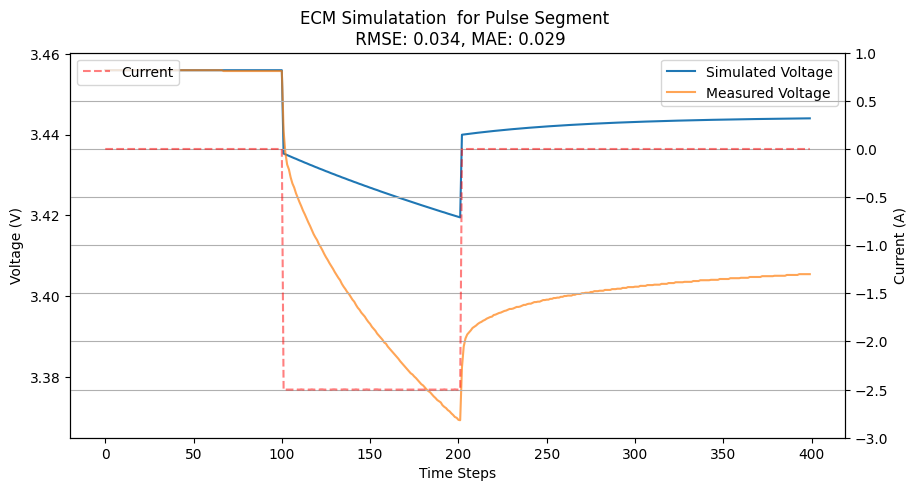

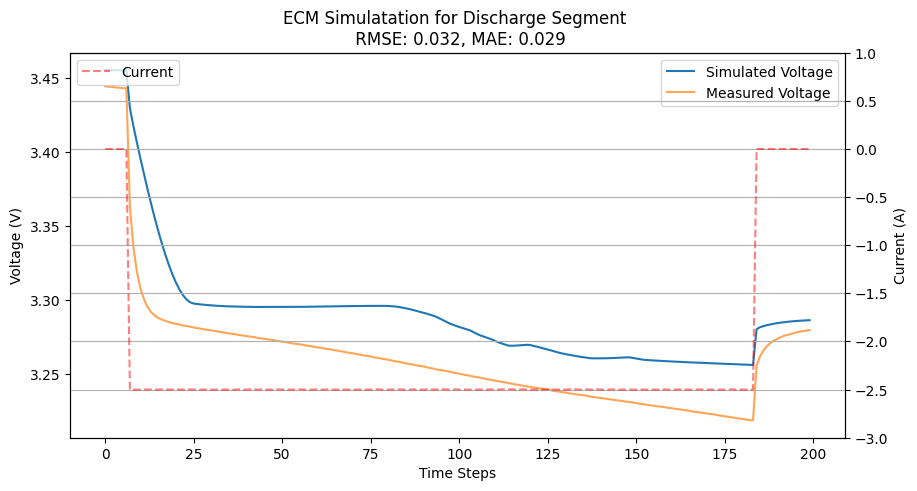

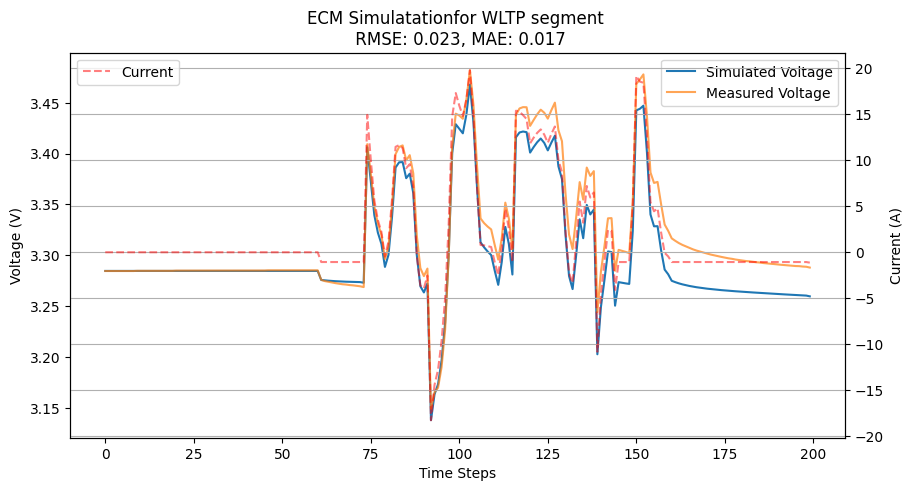

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(voltage_sim1, label='Simulated Voltage')
plt.plot(segment_test1.Voltage, label='Measured Voltage', alpha=0.7)
plt.ylabel('Voltage (V)')
plt.xlabel('Time Steps')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(segment_test1.Current, label='Current', color='red', linestyle = '--', alpha=0.5)
plt.ylabel('Current (A)')
plt.ylim(-3,1)
plt.title(f'ECM Simulatation  for Pulse Segment \n RMSE: {rmse1:.3f}, MAE: {mae1:.3f}')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(voltage_sim2, label='Simulated Voltage')
plt.plot(segment_test2.Voltage, label='Measured Voltage', alpha=0.7)
plt.ylabel('Voltage (V)')
plt.xlabel('Time Steps')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(segment_test2.Current, label='Current', color='red', linestyle = '--', alpha=0.5)
plt.ylabel('Current (A)')
plt.ylim(-3,1)
plt.title(f'ECM Simulatation for Discharge Segment \n RMSE: {rmse2:.3f}, MAE: {mae2:.3f}')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(voltage_sim3, label='Simulated Voltage')
plt.plot(segment_test3.Voltage, label='Measured Voltage', alpha=0.7)
plt.ylabel('Voltage (V)')
plt.xlabel('Time Steps')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(segment_test3.Current, label='Current', color='red', linestyle = '--',alpha=0.5)
plt.xlabel('Time Steps')
plt.ylabel('Current (A)')
plt.title(f'ECM Simulatationfor WLTP segment \n RMSE: {rmse3:.3f}, MAE: {mae3:.3f}')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

#### As a final comment, the validation of the model were not satisfactory for pulse and discharge tests probably due to insufficient optimization of parameters and not smoothing noises in the measurements. The WLTP cycle however, shows some deviations but the trends were well captured by the model. This suggests that further improving the parameter fitting, especially R0 (since voltage drop part is not well captured). Additionally temperature and SoH of the battery also effects the parameters. SoH might not be very effective in this case since only BOL data was used.  